This is a continuation of the previous [`eda_1.ipynb`](eda_1.ipynb) notebook because things got a little too long

In [1]:
import matplotlib.pyplot as plt

from pyspark.sql import (
    functions as F,
    Row,
    SparkSession,
)

# init spark session
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [2]:
review_fp = "hdfs://namenode:9000/preprocessed"
df = spark.read.parquet(review_fp, header=True, inferSchema=True)

df.printSchema()
print(f'Total reviews: {df.count()}')
df.show(5)

root
 |-- review: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- place_index: integer (nullable = true)
 |-- sentiment: string (nullable = true)

Total reviews: 4016
+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miếng gà 105k n...|     1|          0| negative|
|Thật tuyệt với gà...|     5|          0| positive|
|Gà ướp vừa vị , m...|     5|          0| positive|
|Quán sạch , đẹp ,...|     5|          0| positive|
|Nhân_viên bự con ...|     5|          0| positive|
+--------------------+------+-----------+---------+
only showing top 5 rows



# Word Count stuff
from last session

In [3]:
import re
from string import punctuation

import pandas as pd
import numpy as np

The list of Vietnamese stopwords are provided at [`stopwords/vietnamese-stopwords`](https://github.com/stopwords/vietnamese-stopwords)

In [4]:
!wget -qO vietnamese-stopwords-dash.txt https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/refs/heads/master/vietnamese-stopwords-dash.txt

stopwords_path = "vietnamese-stopwords-dash.txt"
with open(stopwords_path, encoding='utf-8') as file:
    stopwords = {line.strip() for line in file}
stopwords.update(set(punctuation))


def is_valid_key(key):
    # single string (wc_global)
    if isinstance(key, str): word = key
    # tuple (wc_rating, wc_sent_place,...)
    elif isinstance(key, tuple): word = key[0]
    return (
        word not in stopwords and
        not re.fullmatch(r'^\W+$', word) and # remove punctuation
        not re.fullmatch(r'^\d+$', word) # remove numbers
    )

In [5]:
def word_tokenize(row):
    return [(
        word.lower(), row['rating'],
        row['sentiment'], row['place_index']
        ) for word in row['review'].split()
    ]

tokenized_rdd = df.rdd.flatMap(word_tokenize)

In [6]:
# By sentiment & place_index
wc_sent_place = (tokenized_rdd
    .map(lambda row: ((row[0], row[2], row[3]), 1))
    .reduceByKey(lambda x, y: x + y)
)

filtered_sent_place = wc_sent_place.filter(lambda row: is_valid_key(row[0][0]))

In [7]:
place_names = {
    0: 'Phan Huy Ích',
    1: 'Nguyễn Văn Quá',
    2: 'Pandora',
    3: 'Tân Sơn Nhì',
    4: 'Aeon Mall Tân Phú',
    5: 'Phạm Văn Chiêu',
    6: 'Tops Market',
    7: 'Đồng Đen',
    8: 'Maximark Cộng Hòa',
    9: 'Tân Kỳ Tân Quý',
    10: 'Coopmart Nguyễn Ảnh Thủ',
    11: 'Thống Nhất',
    12: 'Nguyễn Sơn',
    13: 'Vincom Quang Trung',
    14: 'Lý Thường Kiệt',
    15: 'Ngô Gia Tự',
    16: 'Xóm Củi',
    18: 'Quang Trung',
    19: 'Lê Văn Việt',
    20: 'Cách Mạng Tháng 8',
    21: 'Âu Cơ'
}
@F.udf()
def get_place_name(place_num):
    return place_names.get(place_num, f"Unknown Place {place_num}")


sent_place_df = spark.createDataFrame(
    filtered_sent_place.map(lambda row: Row(word=row[0][0], sentiment=row[0][1],
                                            place=row[0][2], count=row[1]))
)
sent_place_df = sent_place_df.withColumn("place_name", get_place_name(F.col("place")))

# Word Count by Sentiment & Place_Index

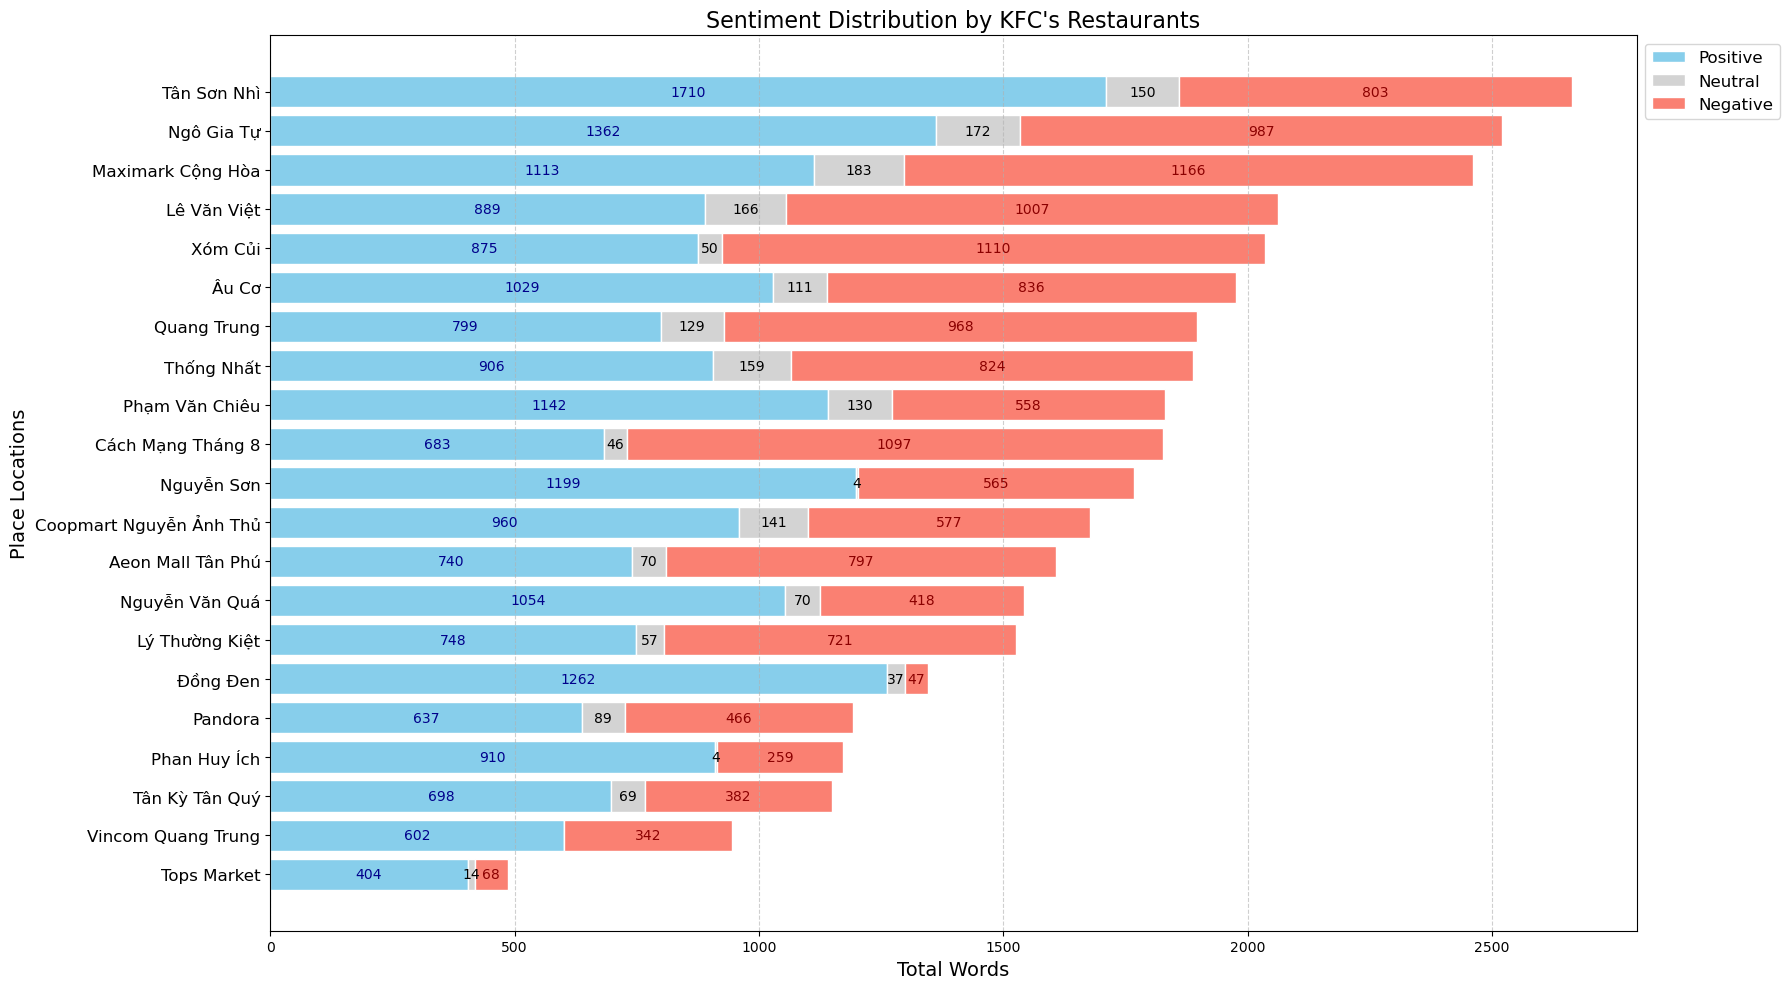

In [15]:
sentiment_by_place = (
    sent_place_df.groupBy("place_name", "sentiment")
    .agg(F.sum("count").alias("total_count"))
    .orderBy("place_name")
)

pdf = sentiment_by_place.toPandas()
pivot_df = pdf.pivot(index="place_name", columns="sentiment", values="total_count").fillna(0)

for sentiment in ['positive', 'neutral', 'negative']:
    if sentiment not in pivot_df.columns:
        pivot_df[sentiment] = 0

# Visualize stacked bar
plt.figure(figsize=(18, 10))
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values('Total', ascending=True)

p1 = plt.barh(pivot_df.index, pivot_df['positive'], 
              color='skyblue', label='Positive', edgecolor='white')
p2 = plt.barh(pivot_df.index, pivot_df['neutral'], 
              left=pivot_df['positive'],
              color='lightgray', label='Neutral', edgecolor='white')
p3 = plt.barh(pivot_df.index, pivot_df['negative'], 
              left=pivot_df['positive'] + pivot_df['neutral'],
              color='salmon', label='Negative', edgecolor='white')

for i, place in enumerate(pivot_df.index):
    # Positive
    if pivot_df['positive'].iloc[i] > 0:
        plt.text(pivot_df['positive'].iloc[i]/2, i,
                str(int(pivot_df['positive'].iloc[i])), 
                va='center', ha='center', color='darkblue', fontsize=10)
    
    # Neutral
    if pivot_df['neutral'].iloc[i] > 0:
        plt.text(pivot_df['positive'].iloc[i] + pivot_df['neutral'].iloc[i]/2, i,
                str(int(pivot_df['neutral'].iloc[i])), 
                va='center', ha='center', color='black', fontsize=10)
    
    # Negative
    total = pivot_df['positive'].iloc[i] + pivot_df['neutral'].iloc[i] + pivot_df['negative'].iloc[i]
    if pivot_df['negative'].iloc[i] > 0:
        plt.text(pivot_df['positive'].iloc[i] + pivot_df['neutral'].iloc[i] + pivot_df['negative'].iloc[i]/2, i,
                str(int(pivot_df['negative'].iloc[i])), 
                va='center', ha='center', color='darkred', fontsize=10)

plt.yticks(range(len(pivot_df.index)), pivot_df.index, fontsize=12)
plt.xlabel('Total Words', fontsize=14)
plt.ylabel('Place Locations', fontsize=14)
plt.title("Sentiment Distribution by KFC's Restaurants", fontsize=16)
plt.legend(fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Word Cloud for Negative Reviews by Place

Let's see what the pain points for each place are.

In [ ]:
neg_rev_by_place = {place: sent_place_df
    .filter((F.col('place') == place) & (F.col('sentiment') == 'negative'))
    .orderBy('count', ascending=False)
    .select('word', 'count')
    .rdd.collectAsMap()
    for place in place_names
}

In [23]:
from wordcloud import WordCloud

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                      colormap='viridis')

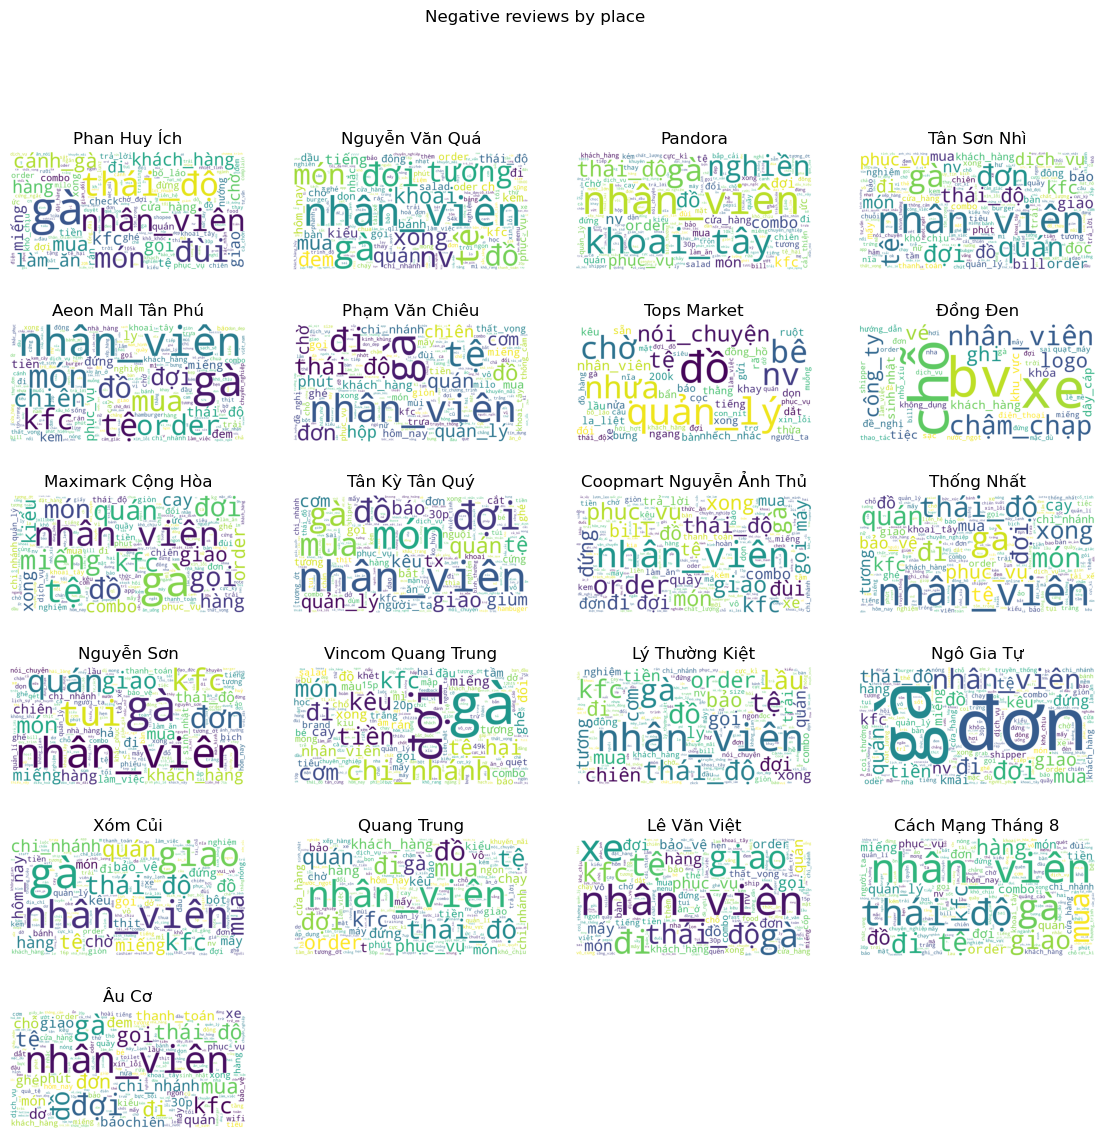

In [55]:
place_idx = list(place_names.keys())
place_idx.extend('.' * 3)

fig = plt.figure(figsize=(14, 13))
ax = fig.subplot_mosaic([[place_idx[row * 4 + col] for col in range(4)]
                        for row in range(6)])

fig.suptitle('Negative reviews by place')
for place, freq_dict in neg_rev_by_place.items():
    ax[place].set_title(place_names[place])
    ax[place].axis('off')

    ax[place].imshow(wordcloud.generate_from_frequencies(freq_dict))

Let's see the reviews at the 15th place

In [17]:
top20 = (df.filter((F.col('place_index') == 15) & (F.col('sentiment') == 'negative'))
    .select('review').collect()
)
for row in top20:
    print(f"""\033[34;1mReview:\033[0m
  {row['review']}
""")

Review:
  Gà truyền_thống vừa bở rẹp vừa ngấm dầu . Mình góp_ý thì nhân_viên và quản_lý đều nói gà truyền_thống là như_vậy , chiên trong nồi áp_suất nên nó sẽ mềm không được giòn . Ok chấp_nhận gà mềm , không giòn . Nhưng chẳng_lẽ gà truyền_thống là gà mềm , không giòn , bở rẹp và ngấm dầu hả ta ? ? ?

Review:
  hôm_qua có ưu_đãi 99k 4 miếng gà nên em đã tới cửa_hàng mua vì em thấy ưu_đãi hời . đến quán khi em bấm máy oder thì chỉ thấy có 4 khách đang đợi món . em oder phần 99k 1 bugrer tôm , 2 kem socola , 2 nước coca lớn , 1 phần mỳ ý gà viên . em oder xong thì có khoảng 3 khách vào nữa . em được nv báo là đợi 15p . khi 4 khách kia đã có món và em nghĩ là tới em nhưng không ạ . hết 4 khách trước em thì tới 3 khách tới sau em cũng đã có món và họ đã ra về hết . em có lại hỏi nv thì bạn báo hết gà , em cũng hỏi sao em tới trước mà_lại ra món cho khách tới sau . bạn nv đứng quầy trl em với thái_độ khó_chịu ' trong phần oder của chị có gà kmãi nên ưu_tiên cho khách không mua gà kmãi trướ